In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=b37192a352f7b77259770a22b316ff66417589c7e4e8a3850f20cf4b20da58cd
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import IntegerType

# Initialize Spark session
spark = SparkSession.builder.appName("LoanApproval").getOrCreate()

from google.colab import drive
drive.mount("/content/drive")

# Load dataset
file_path = "/content/drive/MyDrive/loan dataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display schema and initial data
df.printSchema()
df.show(5)

# Check for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Fill missing values
df = df.fillna({
    'Gender': 'Male',
    'Married': 'No',
    'Dependents': '0',
    'Self_Employed': 'No',
    'Credit_History': 1.0,
    'LoanAmount': df.select("LoanAmount").agg({"LoanAmount": "mean"}).first()[0],
    'Loan_Amount_Term': df.select("Loan_Amount_Term").agg({"Loan_Amount_Term": "mean"}).first()[0]
})

# Verify missing values are filled
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credi

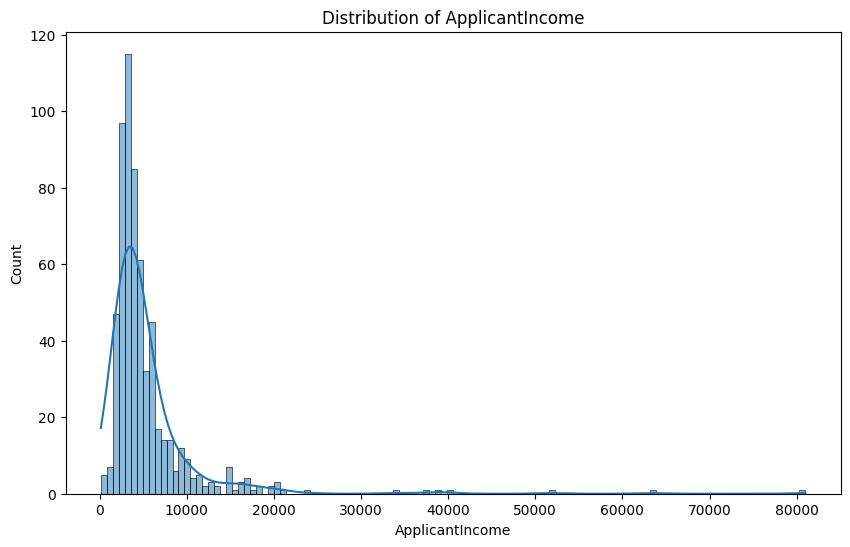

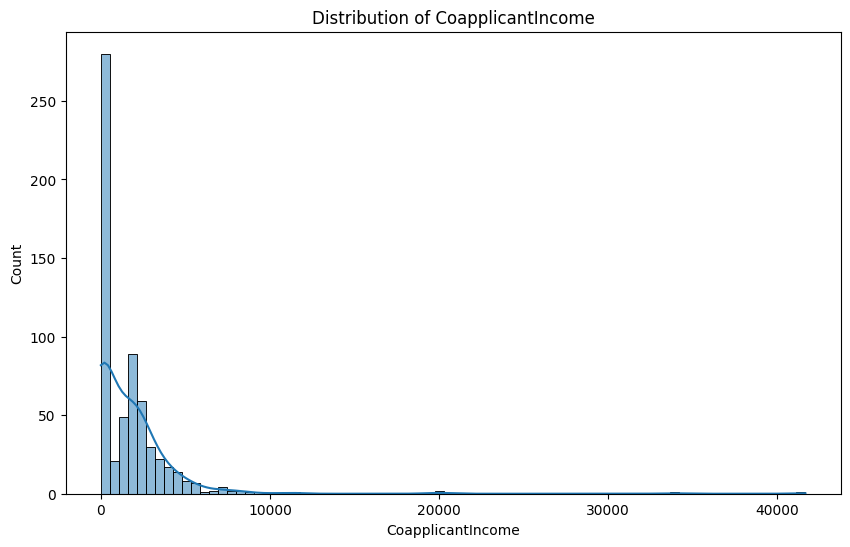

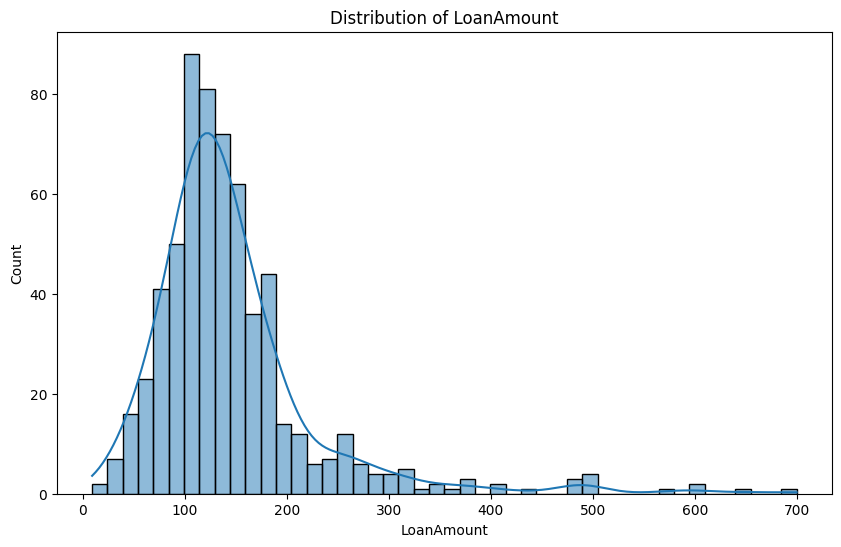

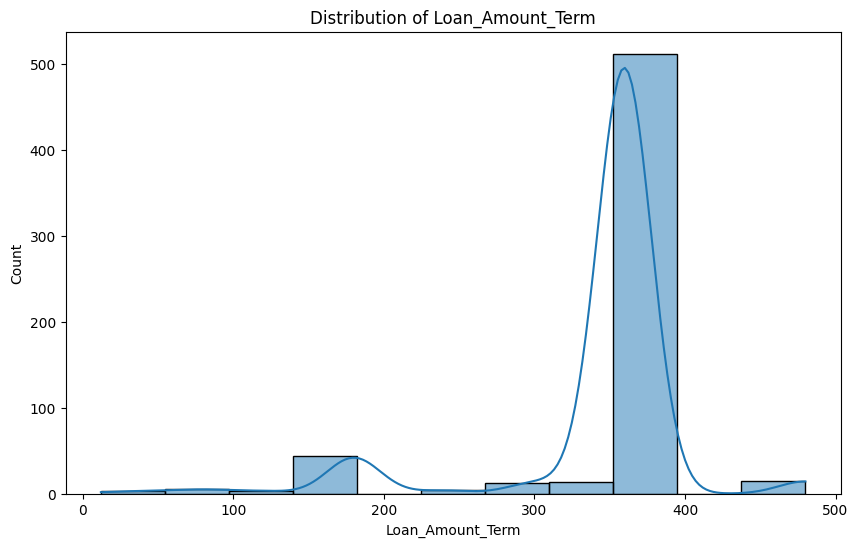

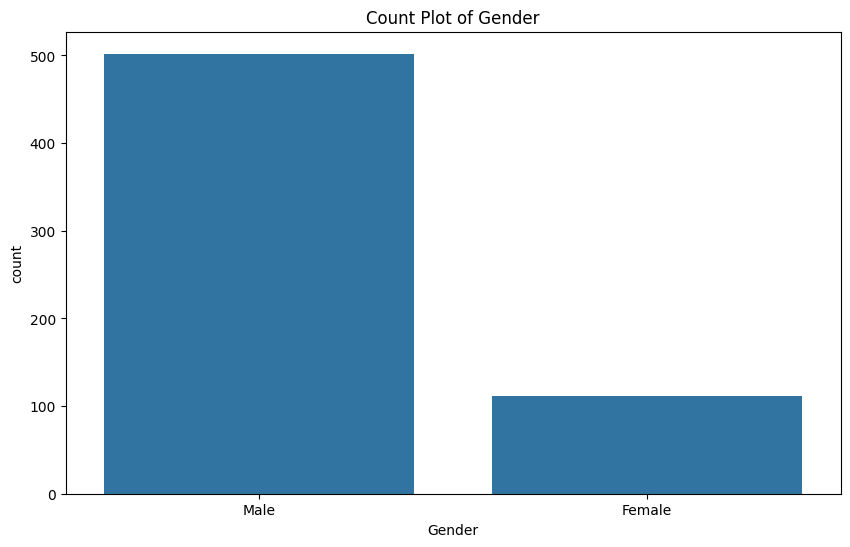

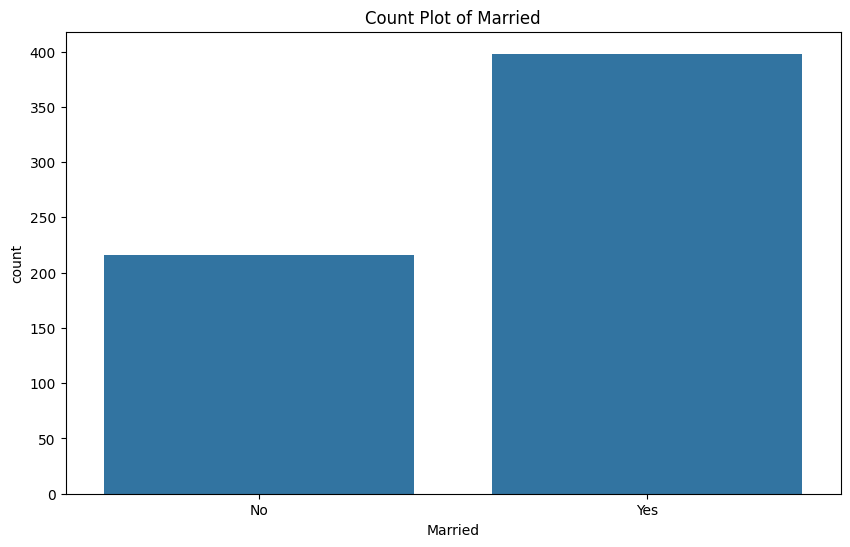

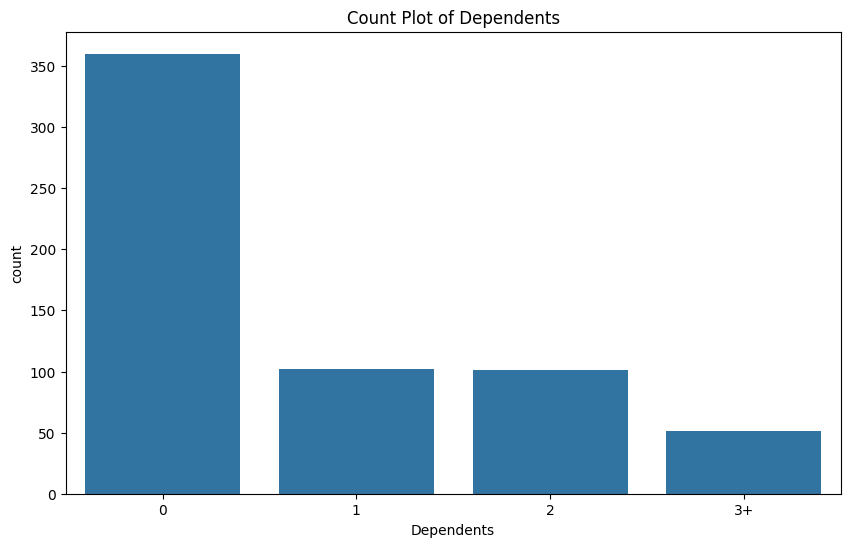

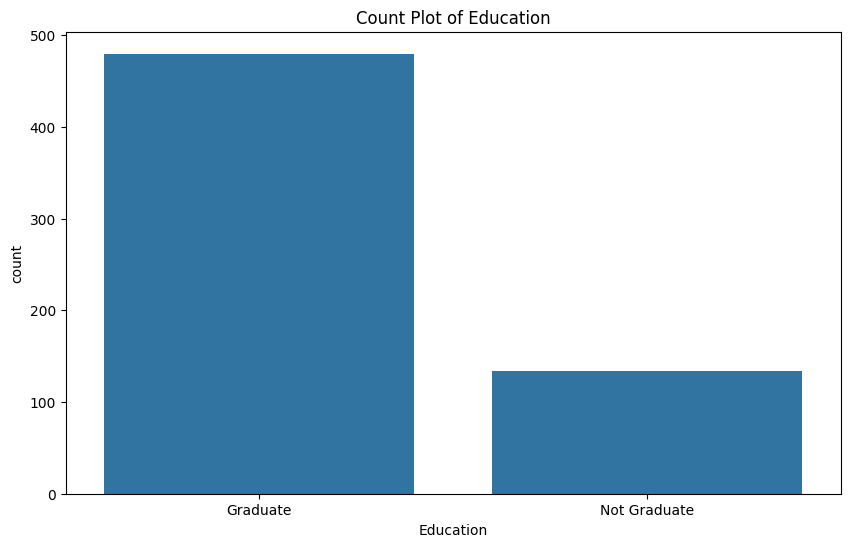

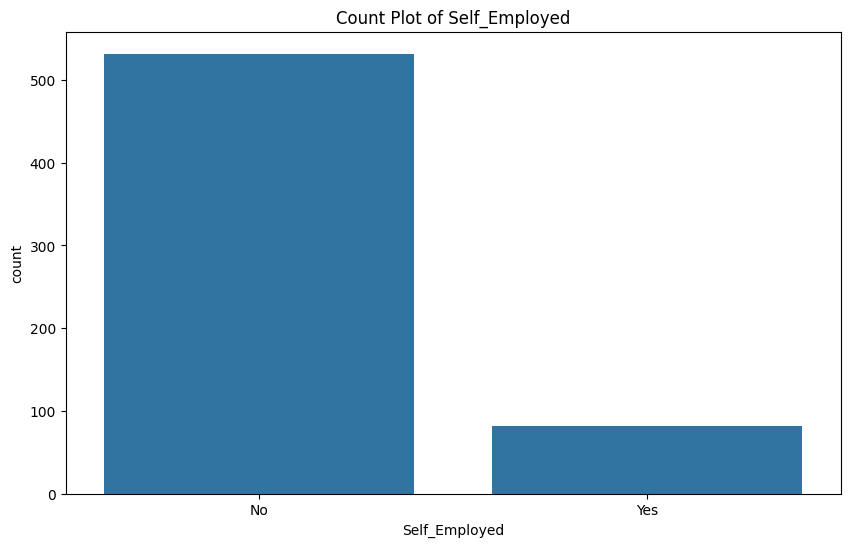

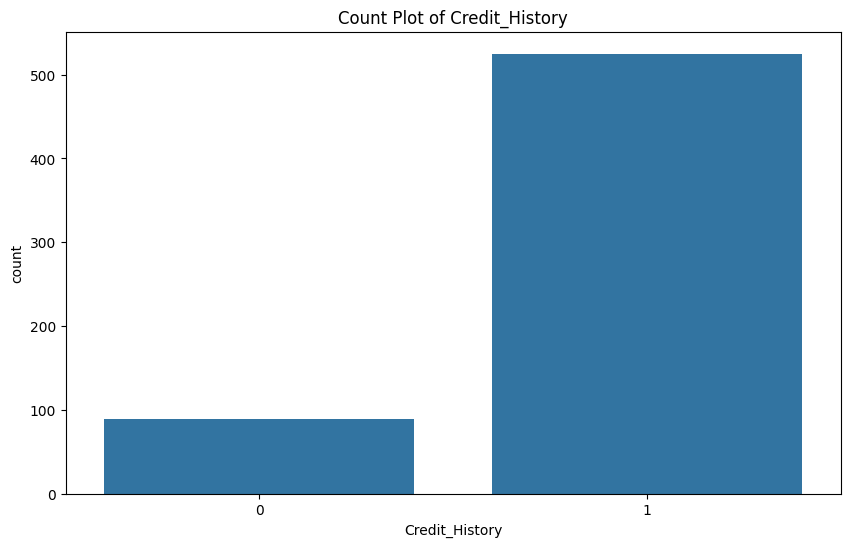

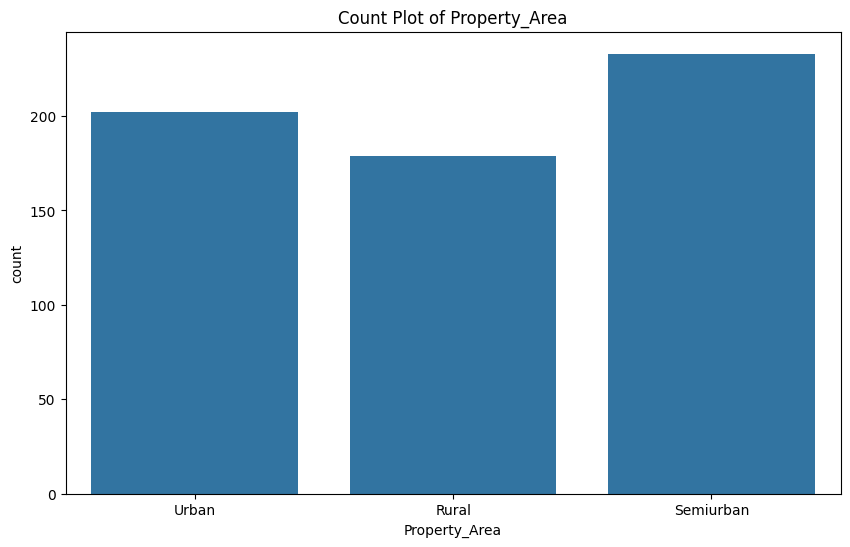

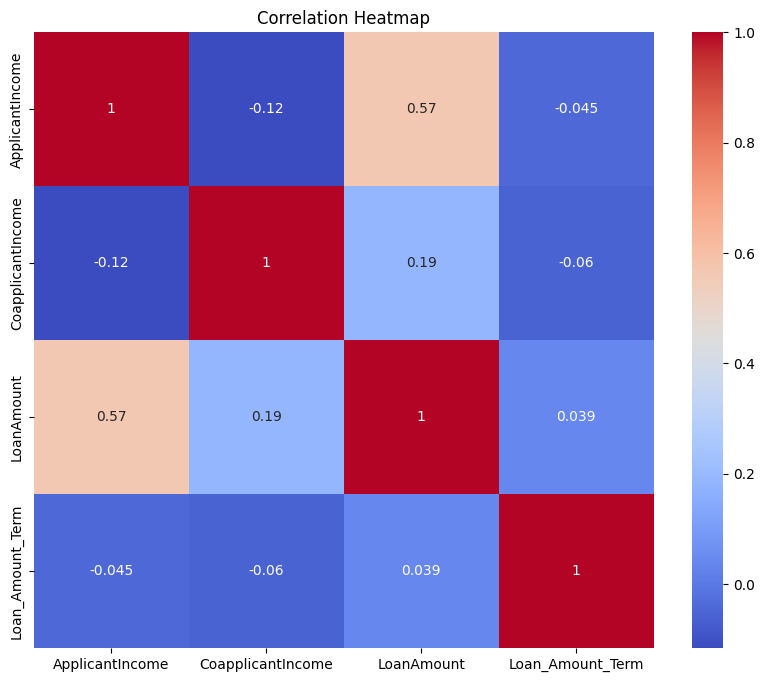

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to Pandas for EDA
df_pd = df.toPandas()

# Plotting distributions of numerical features
num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
for feature in num_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_pd[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Plotting count plots for categorical features
cat_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
for feature in cat_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df_pd[feature])
    plt.title(f'Count Plot of {feature}')
    plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df_pd[num_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# StringIndexer for categorical features
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in cat_features]

# OneHotEncoder for indexed categorical features
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+"_encoded") for indexer in indexers]

# VectorAssembler for feature vector
assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders] + num_features,
    outputCol="features"
)

# Define models
lr = LogisticRegression(labelCol="Loan_Status_index", featuresCol="features")
rf = RandomForestClassifier(labelCol="Loan_Status_index", featuresCol="features")
gbt = GBTClassifier(labelCol="Loan_Status_index", featuresCol="features")

# Define stages of the pipeline
stages = indexers + encoders + [assembler]

# Logistic Regression Pipeline
pipeline_lr = Pipeline(stages=stages + [lr])

# Random Forest Pipeline
pipeline_rf = Pipeline(stages=stages + [rf])

# Gradient-Boosted Tree Pipeline
pipeline_gbt = Pipeline(stages=stages + [gbt])


In [ ]:
# Convert Loan_Status to numeric
df = StringIndexer(inputCol="Loan_Status", outputCol="Loan_Status_index").fit(df).transform(df)

# Split the data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Train and evaluate Logistic Regression
model_lr = pipeline_lr.fit(train_data)
predictions_lr = model_lr.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Loan_Status_index")
print("Logistic Regression AUC: ", evaluator.evaluate(predictions_lr))

# Train and evaluate Random Forest
model_rf = pipeline_rf.fit(train_data)
predictions_rf = model_rf.transform(test_data)
print("Random Forest AUC: ", evaluator.evaluate(predictions_rf))

# Train and evaluate Gradient-Boosted Tree
model_gbt = pipeline_gbt.fit(train_data)
predictions_gbt = model_gbt.transform(test_data)
print("Gradient-Boosted Tree AUC: ", evaluator.evaluate(predictions_gbt))


Logistic Regression AUC:  0.667816091954023
Random Forest AUC:  0.7033045977011496
Gradient-Boosted Tree AUC:  0.6126436781609198
